![Radio Paradise Logo](https://i.pinimg.com/originals/20/7f/68/207f68a2f651cf3f96999d711bb74502.jpg)

### Introduction

In today's world, music recommendation engines are commonplace - companies like Spotify, Apple and Amazon provide music suggestions based on your previous listening behavior. 

For a few years, I have been an avid listener of Radio Paradise, an online radio station that plays an eclectic selection of music. This website allows you to rate songs from 1 to 10, 1 indicating that you did not like the song and 10 indicating that you loved the song. Gradually, this has allowed me to build up a rich dataset of my personal music preferences across a wide variety of genres.

The Last FM dataset (referenced below) contains descriptors or 'tags' for about one million songs from the last couple of decades. In this notebook, we will explore whether we can use these song tags and artist names to suggest new music, based on my indicated preferences. In other words, the tags and artists will be the features in a song preference prediction model. 

##### Last.fm dataset, the official song tags and song similarity collection for the Million Song Dataset, available at: http://labrosa.ee.columbia.edu/millionsong/lastfm

In [2]:
import pandas as pd
import json
import os
import numpy as np
import sys

### Loading the raw data 

The Last FM dataset can be downloaded as a set of JSON files. Each song has its own JSON file. We need to extract the data from these files.

In [2]:
train_data_location = r'C:\Users\roald\Documents\lastfm_train'
test_data_location = r'C:\Users\roald\Documents\lastfm_test'

files_to_mine = []
for f in [train_data_location, test_data_location]:
    for f1 in os.listdir(f):
        folder_location_1 = f + '\\' + f1
        for f2 in os.listdir(folder_location_1):
            folder_location_2 = folder_location_1 + '\\' + f2
            for f3 in os.listdir(folder_location_2):
                folder_location_3 = folder_location_2 + '\\' + f3
                for json_music_file in os.listdir(folder_location_3):
                    full_file_location = folder_location_3 + '\\' + json_music_file
                    files_to_mine.append(full_file_location)

print(len(files_to_mine), 'files have been downloaded')

943334 files have been downloaded


In [3]:
# extract the data from the json files and load into two separate dataframes,
# one with the song title and artist and one with the song title and various tags

all_songs = {}
for file in files_to_mine:
    with open(file, 'r') as f:
        music_file_contents = json.load(f)
        track_id = music_file_contents['track_id']
        all_songs[track_id] = music_file_contents

all_songs_dataframe = pd.DataFrame.from_dict(all_songs, orient='index')

all_songs_tabular = all_songs_dataframe.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
all_songs_tabular.name = 'tags'
all_songs_dataframe = all_songs_dataframe.drop('tags', axis=1).join(all_songs_tabular)
all_songs_dataframe.dropna(subset=['tags'], axis=0, inplace=True)
all_songs_dataframe['tag'] = all_songs_dataframe.tags.apply(lambda x: x[0])

all_songs_dataframe = all_songs_dataframe[['title', 'artist', 'tag']]
all_songs_dataframe.to_csv('all_raw_data.csv')
all_songs_dataframe.head()

,title,artist,tag
TRAAAAK128F9318786,Scream,Adelitas Way,alternative rock
TRAAAAK128F9318786,Scream,Adelitas Way,rock
TRAAAAK128F9318786,Scream,Adelitas Way,hard rock
TRAAAAK128F9318786,Scream,Adelitas Way,heavy metal
TRAAAAK128F9318786,Scream,Adelitas Way,00s


For the purpose of this modeling exercise, the artists and tags will be our features - we will not distinguish between the two in any meaningful way. In many cases, the artist name is listed as one of the tags anyway! Let's make sure that the artist and tag info sits in the same column.

In [7]:
all_songs_dataframe = pd.read_csv('all_raw_data.csv', index_col=0, encoding='latin-1')

all_songs_artists = all_songs_dataframe[['title', 'artist']]
all_songs_artists.columns = ['title', 'attribute']
all_songs_artists.to_csv('song_artist_info.csv')

all_songs_tags = all_songs_dataframe[['title', 'tag']]
all_songs_tags.columns = ['title', 'attribute']

all_songs_concat = pd.concat([all_songs_artists, all_songs_tags], axis=0)
all_songs_concat.drop_duplicates(subset=['title','attribute'], inplace=True)
all_songs_concat = all_songs_concat.dropna(subset=['attribute'], axis=0)

# save to csv so that does not need to be stored in memory throughout
all_songs_concat.to_csv('all_song_table.csv')
all_songs_concat.head()

,title,attribute
TRAAAAK128F9318786,Scream,Adelitas Way
TRAAAAW128F429D538,I Didn't Mean To,Casual
TRAAABD128F429CF47,Soul Deep,The Box Tops
TRAAADJ128F4287B47,Heartache People,Big Brother & The Holding Company
TRAAADZ128F9348C2E,Amor De Cabaret,La Sonora Santanera


### Feature Extraction

The next step is to 'dummify' our attributes. However, it is likely that many of these will only appear for songs that do not have a rating associated with them. To mitigate this issue (after all, we can't generate predictions based on attributes that have never been seen before by a model), we will now merge our song ratings with the attributes table. 

In [8]:
# load the song ratings table into memory
song_ratings = pd.read_csv('C:/Users/roald/Documents/music_ratings.csv')

# retrieve the song_id for all rated songs
all_songs_artists.reset_index(inplace=True)
song_ratings = pd.merge(left=song_ratings, right=all_songs_artists, left_on=['artist', 'song'], right_on=['attribute', 'title'], how='inner')
song_ratings = song_ratings[['index', 'rating']]
song_ratings = song_ratings.drop_duplicates()
song_ratings = song_ratings.set_index('index')

songs_ratings_features = pd.merge(left=all_songs_concat, right=song_ratings, left_index=True, right_index=True, how='right')
songs_ratings_features = songs_ratings_features[['title', 'attribute', 'rating']]
songs_ratings_features.head()

,title,attribute,rating
TRAAKAS128F4246013,Waiting,Porcupine Tree,7
TRAAKAS128F4246013,Waiting,Progressive rock,7
TRAAKAS128F4246013,Waiting,porcupine tree,7
TRAAKAS128F4246013,Waiting,Psychedelic Rock,7
TRAAKAS128F4246013,Waiting,Progressive,7


##### Feature name normalization

From the above, we have seen that the song tags can have somewhat inconsistent spelling and capitalization - some are also very similar (70's and 70s, for instance). To mitigate this, let's do some simple text normalization of the feature names. We will stem the feature names, convert to lower case and remove any special characters, including spaces.

In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

porter_stemmer = PorterStemmer()

In [10]:
def stem_feature_name(feature_name):
    return porter_stemmer.stem(feature_name)

def lower_case(feature_name):
    return str(feature_name).lower()

def remove_special_characters(feature_name):
    return ''.join(a for a in feature_name if a.isalnum())

def convert_to_us_spelling(feature_name):
    if 'ou' in feature_name:
        feature_name = str(feature_name).replace('ou', 'o')
    return feature_name

def normalize_feature_name(feature_name):
    tokenized_feature_name = word_tokenize(feature_name)
    clean_feature_name_components = []
    for t in tokenized_feature_name:
        stemmed_feature_name = stem_feature_name(t)
        lower_case_feature_name = lower_case(stemmed_feature_name)
        clean_feature_name_component = remove_special_characters(lower_case_feature_name)
        clean_feature_name_components.append(clean_feature_name_component)
    cleaner_feature_name = ''.join(clean_feature_name_components)
    clean_feature_name = convert_to_us_spelling(cleaner_feature_name)
    return clean_feature_name

In [11]:
print('Before normalization, we have', len(set(songs_ratings_features['attribute'])), 'unique attributes')

songs_ratings_features['attribute_normalized'] = songs_ratings_features['attribute'].apply(str).apply(normalize_feature_name)

# since some features may, after normalization, have the same name, we will drop any duplicates that were created in the process.
songs_ratings_features.drop_duplicates(subset=['title','attribute_normalized'])

print('After normalization, we have', len(set(songs_ratings_features['attribute_normalized'])), 'unique attributes')

Before normalization, we have 10574 unique attributes
After normalization, we have 9946 unique attributes


Now, let us create dummy variables for each of the attributes in our dataset. 

In [12]:
songs_ratings_features['value'] = 1

ratings_features_dummified = songs_ratings_features.pivot_table(index=[songs_ratings_features.index, 'rating'], columns='attribute_normalized', values='value', aggfunc=np.sum)
ratings_features_dummified = ratings_features_dummified.fillna(0)
ratings_features_dummified.head()

,attribute_normalized,00,0001,0004,0096225121108105,00altern,00alternrock,00rock,00s,0777,1,...,zmin,zmusegorichem,zodiac,zoocore,zootv,zra111,zwischenschlafunderwachenhaengengeblieben,zwischenst,zwoel,zzz
,rating,,,,,,,,,,,,,,,,,,,,,
TRAAKAS128F4246013,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAALAH128E078234A,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRABIOA128F42A6DB1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRABPUY12903CE380F,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRACWWF128F9346965,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Dimensionality Reduction

In order to reduce the effect of overfitting on features that only appear a couple of times, we will ignore any attributes that appear for less than 0.1% of all songs we have a rating for.

In [13]:
number_of_rows = ratings_features_dummified.shape[0]
minimum_count = number_of_rows/1000

ratings_features_dummified.drop([col for col, val in ratings_features_dummified.sum().iteritems() if val < minimum_count], axis=1, inplace=True)
ratings_features_dummified = ratings_features_dummified.fillna(0).reset_index()
ratings_features_dummified = ratings_features_dummified.set_index('level_0')

ratings_features_dummified.head()

attribute_normalized,rating,00,0001,0004,0096225121108105,00altern,00alternrock,00rock,00s,0777,...,zmin,zmusegorichem,zodiac,zoocore,zootv,zra111,zwischenschlafunderwachenhaengengeblieben,zwischenst,zwoel,zzz
level_0,,,,,,,,,,,,,,,,,,,,,
TRAAKAS128F4246013,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAALAH128E078234A,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRABIOA128F42A6DB1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRABPUY12903CE380F,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRACWWF128F9346965,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Despite our exclusion of infrequent tags and artists, we still have a very large number of features. Let's see if we can use a random forest model to reduce the dimensionality of this dataset, and eliminate any variables that seem redundant. 

In [55]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np


y = ratings_features_dummified['rating']
X = ratings_features_dummified.drop(['rating'], axis=1)

feature_names = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

# we have set a threshold for feature importance to yield a maximum of 200 features
sfm = SelectFromModel(clf, max_features=200)
sfm.fit(X_train, y_train)

final_feature_names = []
for feature_list_index in sfm.get_support(indices=True):
    feature_name_to_keep = feature_names[feature_list_index]
    final_feature_names.append(feature_name_to_keep)
    
print(final_feature_names)

['00', '1988', '1994', '2000', '60', '60s', '70', '70rock', '77davezalltrack', '80', '90', 'acidjazz', 'acost', 'adultcontemporari', 'aitch', 'albumiown', 'alleria', 'alltimefavorit', 'alongredglare', 'altcontri', 'altern', 'alternpunk', 'alternrock', 'amaz', 'ambient', 'american', 'americana', 'anim', 'ateas', 'atmospher', 'awesom', 'ballad', 'beauti', 'bestsongever', 'blue', 'blueinfluenc', 'bluesrock', 'bristol', 'british', 'britishinvas', 'britpop', 'calm', 'canadian', 'celtic', 'chill', 'chillot', 'classic', 'classicrock', 'coldcase', 'coldcaseend', 'coleur3', 'contri', 'contrirock', 'cool', 'danc', 'danceabl', 'dark', 'delpu', 'depress', 'docmerlwatson', 'downtempo', 'dreami', 'drive', 'easi', 'easilisten', 'eleanormcevoy', 'electro', 'electron', 'electronica', 'electronicainfluenc', 'emot', 'english', 'epic', 'experiment', 'f', 'fav', 'favorit', 'favoritalbum', 'favoritsong', 'feelgood', 'femalvocal', 'femalvocalist', 'folk', 'folkrock', 'fuckawesom', 'fun', 'funk', 'funki', 'fu

Now that we have narrowed down the overall features to keep, let us modify our dataset accordingly, and save as a CSV file. 

In [56]:
all_columns = ['rating'] + final_feature_names

# it appears there is a feature called 'nan' - this could be a residual null value. To be safe, let's remove it.
all_columns.remove('nan')

rated_songs = ratings_features_dummified[all_columns]
rated_songs.to_csv('full_song_featureset.csv')
rated_songs.head()

attribute_normalized,rating,00,1988,1994,2000,60,60s,70,70rock,77davezalltrack,...,synthpop,triphop,uk,upbeat,vietnam,vocal,weallgetold,wist,world,worldmusic
level_0,,,,,,,,,,,,,,,,,,,,,
TRAAKAS128F4246013,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAALAH128E078234A,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRABIOA128F42A6DB1,9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
TRABPUY12903CE380F,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
TRACWWF128F9346965,8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Inspecting the dependent variable

Let's take a closer look at the song ratings, the variable we are trying to predict.

##### Modeling an ordinal dependent variable

Since we are dealing with song ratings between 1 and 10, our data is ordinal in nature. 

This poses an interesting problem - the actual values on the scale mean little, but the order of the values is highly relevant. A 10 indicates a higher level of preference than a 9, which in turn indicates a higher level of preference than an 8. 

Before we discuss the implications of this for the type of model we will build, let us inspect the dependent variable in more detail. 

In [57]:
song_dataset = pd.read_csv('full_song_featureset.csv', encoding='latin-1')
song_dataset.rename(index=str, columns={'level_0': 'song_id'}, inplace=True)
song_dataset = song_dataset.set_index('song_id')
song_dataset['rating'].value_counts()

8     147
7     142
6      90
9      67
5      22
10     14
4      12
3       6
2       3
1       2
Name: rating, dtype: int64

It appears that some classes are far more frequent than others - ratings between 1-5 are quite rare, as are 10s. To mitigate this effect, we will combine all classes between 1 and 5 into one class, and fold ratings of 10 in with 9s.

This is also an acceptable step from a practical perspective. Any song with a 1-5 rating would be 'bad' and something I would not want to listen to. Anything with a 9 or 10 rating is 'excellent' and would be a song I would definitely want to listen to. 

In [58]:
song_dataset['rating'] = song_dataset['rating'].replace([1, 2, 3, 4], 5).replace(10, 9)
song_dataset['rating'].value_counts()

8    147
7    142
6     90
9     81
5     45
Name: rating, dtype: int64

##### Evaluation metric

In this context, I care more about precision than recall. We want the model to return suggestions that are likely to fall within the suggested rating category, and are less interested in returning all instances of a 7 or an 8. The sklearn classification report allows us to monitor precision across the various classes we have in our dataset, and weighted average precision gives us an indication of the overall precision across all classes.

As a secondary evaluation metric, we are especially interested in the precision for 8s and 9s - after all, these are the song suggestions that I am most likely to want to listen to. To help us evaluate the performance of our models later on, let's write a custom function that can help us evaluate the precision for 8s and 9s specifically.

In [18]:
# Let us define a custom function to compute the weighted average precision for predicted 8s and 9s

from sklearn.metrics import confusion_matrix
import numpy as np

def precision_89s(y_true, y_predicted):
    
    predicted_eights = np.sum(confusion_matrix(y_true, y_predicted)[:, 3])
    predicted_nines = np.sum(confusion_matrix(y_true, y_predicted)[:, 4])
    
    precision_eights = confusion_matrix(y_true, y_predicted)[3, 3]/predicted_eights
    precision_nines = confusion_matrix(y_true, y_predicted)[4, 4]/predicted_nines
    
    weighted_avg_precision_89 = (precision_eights*predicted_eights + precision_nines*predicted_nines)/(predicted_eights + predicted_nines)
    
    return weighted_avg_precision_89

Almost ready to start building a model! As a final step, let us identify a training and test set.

In [63]:
y = song_dataset['rating']
X = song_dataset.drop(['rating'], axis=1)

# split the dataset into a train and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

### Modeling

Now that we have engineered features and have spent some time inspecting the dependent variable, we are ready to start modeling.

We will first explore the performance of a discrete ordinal regression model, which is specialized to this type of application. We will then explore whether we can achieve better predictive performance using an alternative type of model. 

##### Ordinal Logistic Regression

The discrete ordinal regression model of choice will be ordinal logistic regression (all-threshold variant). The loss function for this ordinal logistic regression model implicitly minimizes the crossing of 'tresholds' - if a song is a 9, predicting a 4 crosses more 'tresholds' than predicting a 6. Details on this algorithm can be found in the article referenced below:

##### J. D. M. Rennie and N. Srebro, “Loss Functions for Preference Levels : Regression with Discrete Ordered Labels,” in Proceedings of the IJCAI Multidisciplinary Workshop on Advances in Preference Handling, 2005.

In [64]:
import mord
from sklearn.metrics import classification_report

ordinal_model = mord.LogisticAT()
ordinal_model.fit(X_train, y_train)
predictions_mord = ordinal_model.predict(X_test)

print(classification_report(y_test, predictions_mord))
print(precision_89s(y_test, predictions_mord))

              precision    recall  f1-score   support

           5       0.10      0.10      0.10        10
           6       0.42      0.24      0.30        21
           7       0.29      0.64      0.40        42
           8       0.36      0.15      0.22        52
           9       0.47      0.26      0.33        27

   micro avg       0.32      0.32      0.32       152
   macro avg       0.33      0.28      0.27       152
weighted avg       0.35      0.32      0.29       152

0.40540540540540543


The baseline performance of our ordinal logistic regression model is rather poor, hardly outperforming a random guess.

#### XGBoost

Now that we have established a baseline using a model designed to model ordinal data, let us take an alternative approach. Although our dependent variable is ordinal, we could also choose to view this problem as one of multiclass classification.

XGBoost is a well-known gradient boosting algorithm that has performed very well in Kaggle competitions over the last couple of years. The XGBoost algorithm is explained in more detail in the following article:

https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html

Let us start by seeing what predictive performance we can get using a 'vanilla' xgboost classifier.

In [65]:
import xgboost as xgb

xg_model = xgb.XGBClassifier()
xg_model.fit(X_train, y_train)
predictions_xgb = xg_model.predict(X_test)

print(classification_report(y_test, predictions_xgb))
print(precision_89s(y_test, predictions_xgb))

              precision    recall  f1-score   support

           5       0.00      0.00      0.00        10
           6       0.09      0.05      0.06        21
           7       0.35      0.38      0.36        42
           8       0.42      0.65      0.51        52
           9       0.33      0.15      0.21        27

   micro avg       0.36      0.36      0.36       152
   macro avg       0.24      0.25      0.23       152
weighted avg       0.31      0.36      0.32       152

0.40860215053763443


In [22]:
from sklearn.model_selection import GridSearchCV

# ignore warnings - iterating through the grid search will throw a depreciation error
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# instatiate a fresh, unfitted xgboost classifier
xgb_model = xgb.XGBClassifier()

We will run a simple, cross-validated grid search with 5 stratified folds. We can use our 'weighted average precision for 8s and 9s' function as the scoring function for this grid search. 

The XGBoost algorithm has a plethora of hyperparameters we might optimize. However, in the interested of (computing) time we will focus on just a few. We will run a search based on the hyperparameters selected for optimization in the following article:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [23]:
from sklearn.metrics import make_scorer

scoring = make_scorer(precision_89s)

param_test = {
    'min_child_weight': [1, 3, 5, 7],
    'max_depth': [1, 3, 6, 9],
    'gamma': [0, 0.5, 1, 2],
    'subsample':[0.6, 0.8, 1],
    'colsample_bytree':[0.6, 0.8, 1],
    'reg_alpha':[0, 0.01, 0.02, 0.05],
    'n_estimators':[5, 10, 20, 50, 100, 500]
}

gsearch = GridSearchCV(estimator = xgb_model, param_grid = param_test, cv=5, scoring=scoring)

gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)

{'colsample_bytree': 1, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'reg_alpha': 0, 'subsample': 0.8}
0.3837064365241452


Now, we will train the model with this set of optimal parameters and evaluate the performance on the test set. This should compare favorably to the initial benchmark.! We will set a lower learning rate than the standard to (hopefully) find the best solution.

In [66]:
xg_model = xgb.XGBClassifier(**gsearch.best_params_)
xg_model.fit(X_train, y_train)

predictions = xg_model.predict(X_test)

print(classification_report(y_test, predictions))
print(precision_89s(y_test, predictions))

              precision    recall  f1-score   support

           5       0.00      0.00      0.00        10
           6       0.08      0.05      0.06        21
           7       0.35      0.45      0.39        42
           8       0.43      0.63      0.51        52
           9       0.50      0.15      0.23        27

   micro avg       0.38      0.38      0.38       152
   macro avg       0.27      0.26      0.24       152
weighted avg       0.34      0.38      0.33       152

0.43529411764705883


The overall performance of our model is better than our initial baseline, but still rather poor. Ideally, I would like to be more than 44% confident that a song that is suggested to me will be one that I like! 

Nevertheless, let's find out what artists and tags I feel strongly about in a song. Conveniently, XGBoost has a built-in feature importance module. 

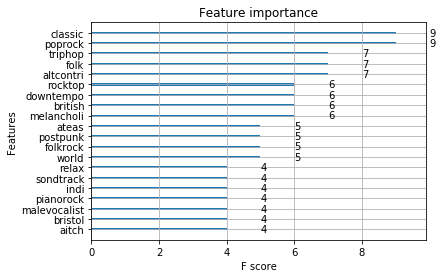

In [67]:
from xgboost import plot_importance
from matplotlib import pyplot as plt

plot_importance(xg_model, max_num_features=20)
plt.show()

It appears that the tags 'classic', 'poprock' and 'triphop' are attribute of a song that drive whether I like or dislike a song. 'Triphop' is not much of a surprise, since Massive Attack and Portishead are two of my favorite bands.

Since we do not have the largest dataset, we want to use all available data to train our final model. As such, we will now retrain the XGBoost model on the complete dataset. 

In [68]:
xg_model = xgb.XGBClassifier(eta=0.005, **gsearch.best_params_)
xg_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.005, gamma=1, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

### Generating Music Suggestions

With our trained model, let's generate rating predictions for 100 randomly chosen songs. First, we need to prepare the data for these new songs.

In [69]:
# extract a list with the names of all the independent variables
relevant_features = list(X.columns)

songs = pd.read_csv('all_song_table.csv', encoding='latin-1', names=['song_id', 'title', 'attribute'], skiprows=1).drop_duplicates()

songs_sample = songs.sample(n=100, axis=0)
songs_to_predict = list(songs_sample['song_id'])              
songs = songs[songs['song_id'].isin(songs_to_predict)]

songs['attribute_normalized'] = songs['attribute'].apply(str).apply(normalize_feature_name)
songs.loc[~songs['attribute_normalized'].isin(relevant_features), 'attribute_normalized'] = 'other'
songs = songs.drop_duplicates(subset=['song_id', 'attribute_normalized'])

songs['count'] = 1

songs = songs.pivot_table(index='song_id', columns='attribute_normalized', values='count', aggfunc=np.sum)

for f in relevant_features:
    if f not in list(songs.columns):
        songs[f] = 0
        
songs = songs[relevant_features]
songs = songs.fillna(0)
songs.head()

attribute_normalized,00,1988,1994,2000,60,60s,70,70rock,77davezalltrack,80,...,synthpop,triphop,uk,upbeat,vietnam,vocal,weallgetold,wist,world,worldmusic
song_id,,,,,,,,,,,,,,,,,,,,,
TRAJZQH128F424A4E6,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
TRAMRBI128F42696BF,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
TRBDSFP128E07937B9,0.0,0.0,0,0.0,0.0,0,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
TRBKPFS128F4273E2B,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
TRBKTRV128F146A429,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1.0,0,0.0,0.0,0.0


Having prepared the data, we can now return predictions for each.

In [70]:
songs_artists = pd.read_csv('song_artist_info.csv', encoding='latin-1', names=['song_id', 'title', 'artist'], skiprows=1).drop_duplicates()

song_predictions = list(xg_model.predict(songs))
ids_predictions = pd.DataFrame(list(zip(songs.index, song_predictions)), columns=['song_id', 'prediction'])

titles_predictions = pd.merge(songs_artists, ids_predictions, left_on='song_id', right_on='song_id')
titles_predictions = titles_predictions[['artist', 'title', 'prediction']]
titles_predictions.sort_values(by='prediction', ascending=False, inplace=True)
titles_predictions

,artist,title,prediction
66,Tricky,Dear God,9
1,Darkthrone,Eon,8
61,Marcus Miller,Mr. Pastorius,8
60,Tiësto,A Tear In The Open,8
59,Charley Pride,Roll On Mississippi,8
54,Vivian Girls,Survival,8
53,????? ????????,Dancing Lasha Tumbai,8
52,Jonathan Rhys Meyers,Elgar / Something Inside,8
51,Denis Leary,Merry Fuckin' Christmas (Live),8
0,Robert Hood,Escapes,8


#### Conclusion

We have gone through several steps to build a model that can suggest new songs, based on preferences I have indicated by rating music on the Radio Paradise station. There are several potential shortcomings of our model, such as the fact that the songs played on Radio Paradise have not been sampled from the same population as the LastFM database with song tags & artist names. Suggestions for songs that would fall outside the set of genres typically played on Radio Paradise may be less reliable. In addition, the set of independent variables is relatively rudimentary. Tags (many of which are seemingly similar) that have been assigned by a third party and artist names are the only song descriptors we are using. In reality, a good song suggestion engine could use a variety of other data points such as pitch, melody and lyrics to produce more sophisticated suggestions. 

Overall, there is plenty of room for improvement with our model. In the meantime, I'll enjoy some of the suggestions for new music!